# Gaussian Mixture Models

### Let's work on the most well-known dataset- Iris and see if we can form Gaussian Mixture Models on that dataset

In [3]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.mixture import GaussianMixture as GMM
from sklearn import datasets

sns.set_palette('deep')
iris = datasets.load_iris()

### Now since our data is 4-dimensional and we want to represent it graphically or visualize it, so let's take two of the 4 attributes

In [5]:
X_train=iris.data[:,:2]

In [6]:
d=pd.DataFrame(X_train)

### Let's plot this and see how the values look like in a scatter plot

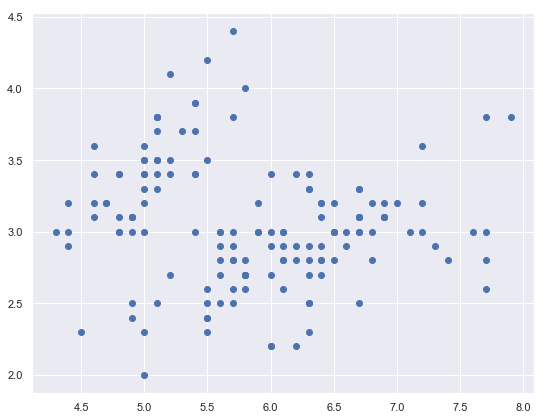

In [40]:
plt.figure(figsize=(9,7))
plt.scatter(d[0],d[1])
plt.show()

### Now since in this case we are aware that our dataset consists of 3 types of iris flowers, so let's fit the data as mixture of 3 Gaussians

### Later we will introduce using AIC and BIC value for getting optimal k cluster value

In [8]:
def plotgmmlabels(d):
    labels = gmm.predict(d) 
    d['labels']= labels
    
    plt.figure(figsize=(9,7))
    plt.scatter(d[0], d[1], c=labels, cmap='viridis')
    plt.show()

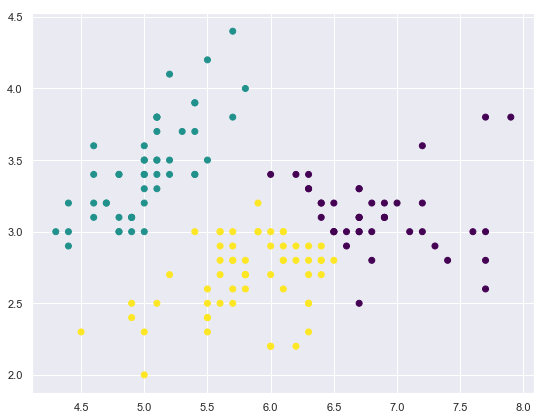

In [39]:
gmm = GMM(n_components = 3)
gmm.fit(d)
plotgmmlabels(d)

### And as simple as it looks, we have our three distinct clusters

### Here below is the converges log-liklihood value and number of iterations it took to converge

In [11]:
print(gmm.lower_bound_)
print(gmm.n_iter_) 

-1.4993383962563336
7


## Let's try to see how the inherit Gaussians of each one of these look like

### For that we first need to create a function that'll give us the heights for each gaussian around a mean and with given covariances

In [12]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=4)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

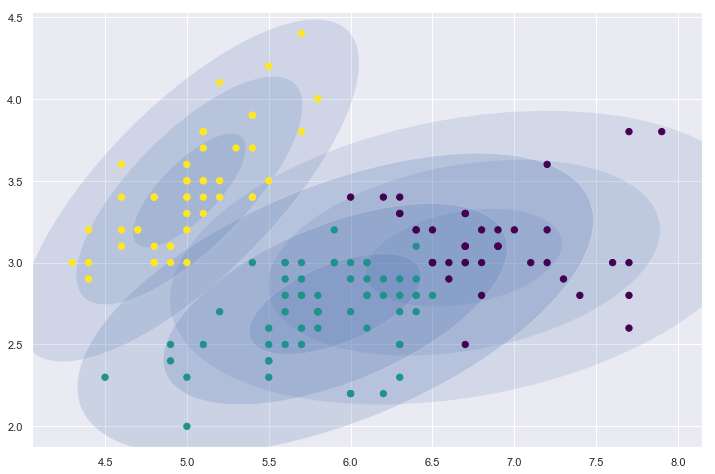

In [38]:
gmm = GMM(n_components=3, random_state=42)
plt.figure(figsize=(12,8))
plot_gmm(gmm, X_train)

### So we see above the underlying Gaussians of each cluster

### One key issue here is though that if let's say we had set number of clusters to be equal to any other number, GMM would had fitted the model likewise, just to show, here it is:

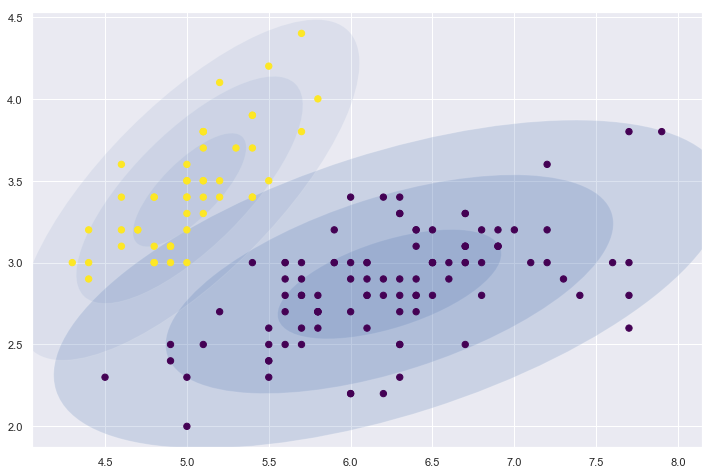

In [37]:
gmm = GMM(n_components=2, random_state=34)
plt.figure(figsize=(12,8))
plot_gmm(gmm, X_train)

### Here GMM has fitted two clusters

### Come to think of it, this looks kinda better than fitting 3 clusters. Don't you think? But weirdly we know there are three kinds of flowers in our iris dataset

### Now this is the same issue we usually have in case of K-means as well. The solution to find that how many clusters will be appropriate for our GMM, we make use of accuracy measures like AIC or BIC(and maybe even that won't help)

### Let's see below how

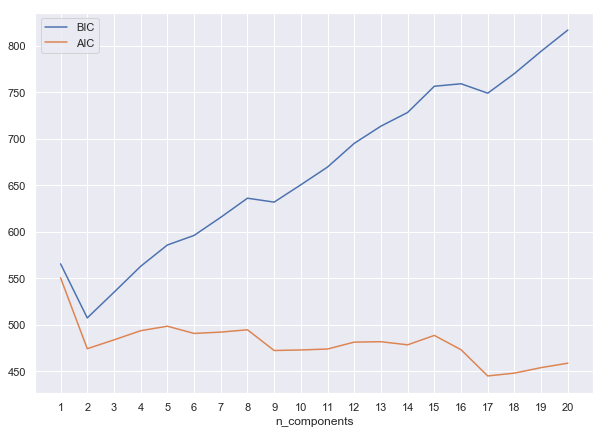

In [36]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(X_train)
          for n in n_components]

plt.figure(figsize=(10,7))

plt.plot(n_components, [m.bic(X_train) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components',)
plt.xticks(n_components);

### As I had feared, since our values are such that they fit 2 cluters perfectly and moreover, as values from two flowers are so similar to eachother, that GMM also suggests to use 2 clusters

### Well this as usual is the same issue as K-mean's and given how the EM algorithm works, was bound to happen with overlapping values but when pre-defined or known the k-value, the results are satisfactory.

### Let's check last time for a dataset with variable clusters

In [16]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)

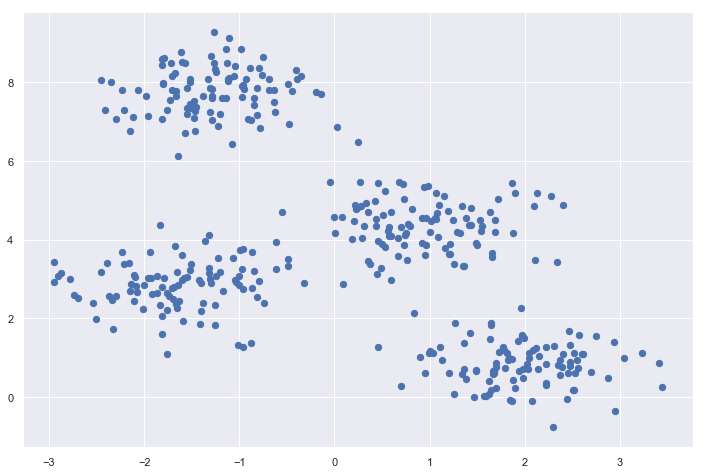

In [35]:
plt.figure(figsize=(12,8))
plt.scatter(X[:, 0], X[:, 1], s=40, cmap='viridis', zorder=4);

### Let's try to see what best k-value does AIC and BIC value suggest for this dataset

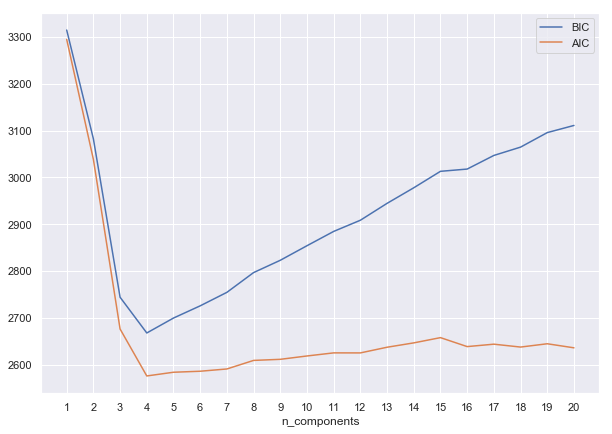

In [34]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.figure(figsize=(10,7))

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components',)
plt.xticks(n_components);

### And there we go, 4 it is as expected

### Let's see the output of assigning 4 clusters to this dataset

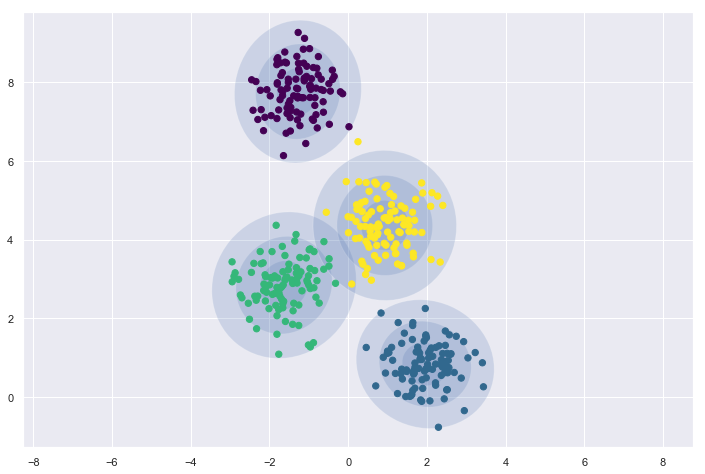

In [33]:
n=4
gmm = GMM(n_components=n, random_state=462)
plt.figure(figsize=(12,8))
plot_gmm(gmm, X)

### Now coming to the part that we want to find out, OUTLIERS

### Gaussian Mixture Models allow assigning a probability to each datapoint of beeing created by one of k gaussian distributions. These are normalized to sum up to one, allowing interpretation as "Which cluster is most probably responsible for this datapoint?"

### What is usually suggested in this case though is that once Gaussians are defined, we can however find the probability of that point being a part of that gaussian cluster via the pdf. By doing so we can have absolute probabilities which estimate how probable a point is - given a specific gaussian mixture model. Then you can simply define an outlier such as: If p < 0.05 for each cluster, then the point is an outlier.

### Let's try this out:

In [20]:
gmm.predict_proba(X).round(3)

array([[0.463, 0.   , 0.   , 0.537],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
       ...,
       [0.   , 1.   , 0.   , 0.   ],
       [0.   , 0.   , 0.437, 0.563],
       [0.   , 1.   , 0.   , 0.   ]])

### As I had expressed earlier, GMM itself does soft clustering and gives the probability of a point being in a cluster and then assigns it to a cluster.

### But as said, these are normalized values and what we want is the probability of a point in a cluster given the pdf of that cluster. We are going to do this via SciPy's stats.multivariatenormal module

In [21]:
from scipy.stats import multivariate_normal

In [24]:
def assign_prob(X):
    outlierlist=[]
    df=pd.DataFrame(X)
    df['label']=gmm.predict(X)
    
    for i in range(len(df)):
        value=df[i:i+1][[0,1]]
        index=df[i:i+1]['label'][i]
        outlierlist.append(multivariate_normal.pdf(value,mean=gmm.means_[index], cov=gmm.covariances_[index]))
    
    return outlierlist

In [26]:
df=pd.DataFrame(X)

In [28]:
df['pdf']=assign_prob(X)

In [29]:
df['outlier']=[1 if a<0.05 else 0 for a in df['pdf'] ]

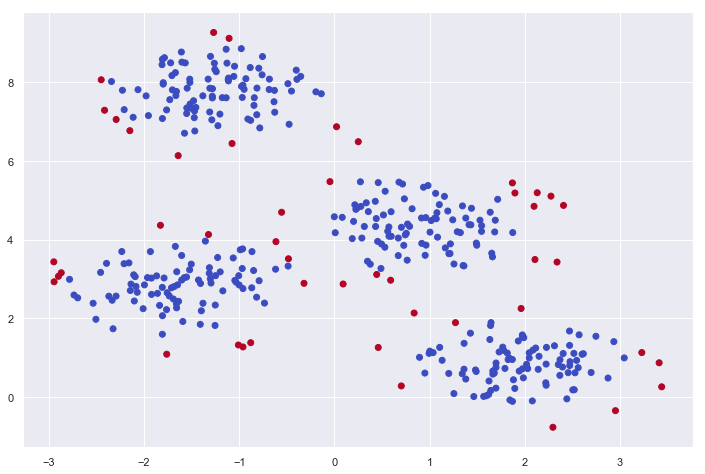

In [32]:
plt.figure(figsize=(12,8))
plt.scatter(df[0], df[1], c=df['outlier'], cmap='coolwarm')
plt.show()